In [1]:
using JuMP, Ipopt, LinearAlgebra, CairoMakie

## Model: Packed bed reactor with axial dispersion model:
$$
\begin{align*}
\cfrac{\partial u_1}{\partial t} & = \cfrac{\partial u_1}{\partial z} + \cfrac{\partial 1}{\partial Pe_m} \cfrac{\partial^2 u_1}{\partial z^2} - B_c exp(\cfrac{\gamma u_2}{1+ u_2}) u_1 \\
\cfrac{\partial u_2}{\partial t} & = \cfrac{\partial u_2}{\partial z} + \cfrac{\partial 1}{\partial Pe_h} \cfrac{\partial^2 u_2}{\partial z^2} - B_t B_c exp(\cfrac{\gamma u_2}{1+ u_2}) u_1 + \beta_T (\theta_c - u_2)\\
\end{align*}
$$

**Bounary condition**:
$$
\begin{gather*}
    & Pe_m(u_1(0)-1)+\frac{1}{Pe_m} = u_1'(0) \\
    & Pe_h u_2(0) = u_2'(0) \\
    & u_1'(0) = 0 \\
    & u_2'(1) = 0
\end{gather*}
$$

**Initial condition**:
$$
\begin{gather*}
    & u_1(t=0) = 0 \\
    & u_2(t=0) = 1
\end{gather*}
$$

- Packed Bed Reactor: https://encyclopedia.che.engin.umich.edu/packed-bed-reactors/

**Parametar**: 

In [2]:
Pem = 5
Peh = 5
Bc = 1e-5
Bt = 1
βT = 15.62
γ = 22.14
θc = 1

1

## 1. Steady state solution: 
$$
\begin{align*}
0 & = \cfrac{\partial u_1}{\partial z} + \cfrac{\partial 1}{\partial Pe_m} \cfrac{\partial^2 u_1}{\partial z^2} - B_c exp(\cfrac{\gamma u_2}{1+ u_2}) u_1 \\
0 & = \cfrac{\partial u_2}{\partial z} + \cfrac{\partial 1}{\partial Pe_h} \cfrac{\partial^2 u_2}{\partial z^2} - B_t B_c exp(\cfrac{\gamma u_2}{1+ u_2}) u_1 + \beta_T (\theta_c - u_2)\\
\end{align*}
$$

In [3]:
# 1-D mesh (spatial)
z_max = 1
dz = 0.001
z_horizon = 1:Int(z_max/dz)

AD_steady = Model(Ipopt.Optimizer)
set_optimizer_attribute(AD_steady, "print_level", 0)

# Define the variables
@variables(AD_steady, begin
    u1[z in z_horizon]
    u2[z in z_horizon]
end)

# Define equations
@NLconstraints(AD_steady, begin
    # PDEs - Centered finite difference
    Steady1[z in z_horizon[begin+1:end-1]], - (u1[z+1]-u1[z-1])/2dz + (u1[z+1]-2u1[z]+u1[z-1])/(dz^2) / Pem-Bc*exp(γ*u2[z]/(1+u2[z]))*u1[z] == 0
    Steady2[z in z_horizon[begin+1:end-1]], - (u2[z+1]-u2[z-1])/2dz + (u2[z+1]-2u2[z]+u2[z-1])/(dz^2) / Peh-Bt*Bc*exp(γ*u2[z]/(1+u2[z]))*u1[z]+βT*(θc-u2[z]) == 0

    # Boundary conditions - Forward FD for *begin*, backward FD for *end*
    Boundary1, Pem*(u1[begin] - 1) == (u1[begin+1]-u1[begin])/dz
    Boundary2, Peh*u2[begin] == (u2[begin+1]-u2[begin])/dz
    Boundary3, (u1[end]-u1[end-1])/dz == 0
    Boundary4, (u2[end]-u2[end-1])/dz == 0
end)

# Number of variables: 2*Nz
# Number of equations: 2*(Nz-2)+4

println("Number of variables: ", num_variables(AD_steady))
println("Number of constraints: ", num_constraints(AD_steady; count_variable_in_set_constraints = true))
println("Degrees of freedom: ", num_variables(AD_steady) - num_constraints(AD_steady; count_variable_in_set_constraints = true))

Number of variables: 2000
Number of constraints: 2000
Degrees of freedom: 0



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



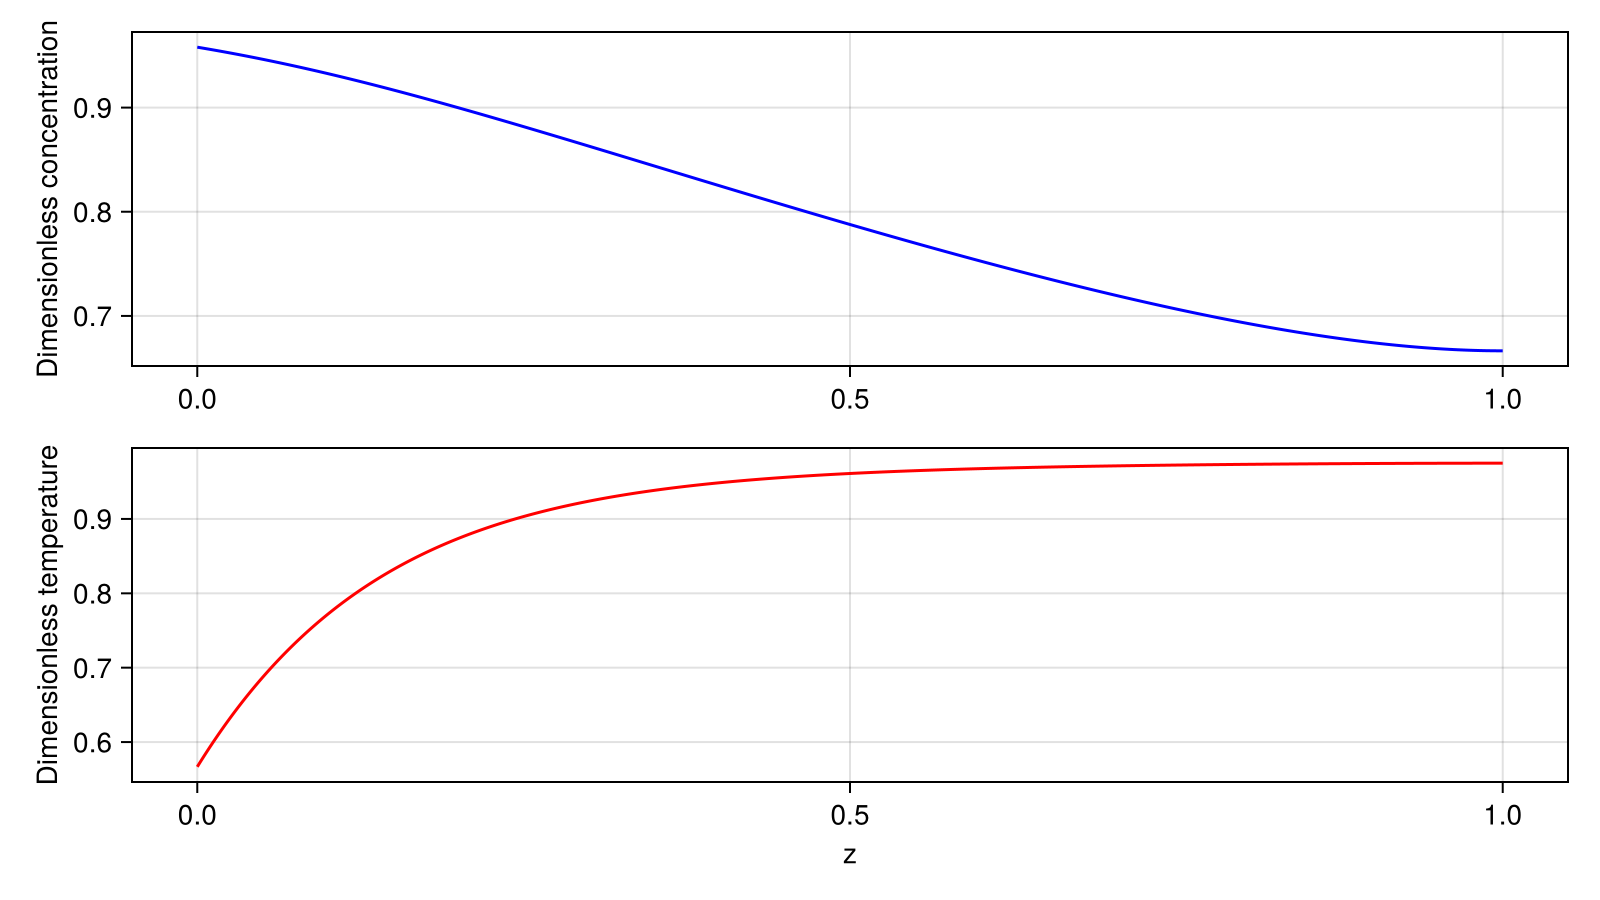

In [4]:
# Solve the model
optimize!(AD_steady)

zs = range(0, 1, length=Int(z_max/dz))
u1s = [value(u1[z]) for z in z_horizon]
u2s = [value(u2[z]) for z in z_horizon]

f = Figure(size = (800, 450))
ax1 = Axis(f[1, 1], ylabel="Dimensionless concentration")
ax2 = Axis(f[2, 1], ylabel="Dimensionless temperature", xlabel="z")

lines!(ax1, zs, u1s, color=:blue, label = ["Steady state"])
lines!(ax2, zs, u2s, color=:red, label = ["Steady state"])

f

## 2. Solution on time and spatial domains

In [5]:
# 2-D mesh (spatial & temporal)
z_max = 1
dz = 0.005
z_horizon = 1:Int(z_max/dz)
Nz = length(z_horizon)

t_max = 2
dt = 0.01
t_horizon = 1:Int(t_max/dt)
Nt = length(t_horizon)

AD = Model(Ipopt.Optimizer)
set_optimizer_attribute(AD, "print_level", 0)

# Define the variables
@variables(AD, begin
    u1[z in z_horizon, t in t_horizon]
    u2[z in z_horizon, t in t_horizon]
end)

@NLconstraints(AD, begin
    Dynamic1[z in z_horizon[begin+1:end-1], t in t_horizon[begin+1:end]], - (u1[z+1,t]-u1[z-1,t])/2dz + (u1[z+1,t]-2u1[z,t]+u1[z-1,t])/(dz^2) / Pem-Bc*exp(γ*u2[z,t]/(1+u2[z,t]))*u1[z,t] == (u1[z,t]-u1[z,t-1])/dt
    Dynamic2[z in z_horizon[begin+1:end-1], t in t_horizon[begin+1:end]], - (u2[z+1,t]-u2[z-1,t])/2dz + (u2[z+1,t]-2u2[z,t]+u2[z-1,t])/(dz^2) / Peh-Bt*Bc*exp(γ*u2[z,t]/(1+u2[z,t]))*u1[z,t]+βT*(θc-u2[z,t]) == (u2[z,t]-u2[z,t-1])/dt
    
    Boundary1[t in t_horizon[begin+1:end]], Pem*(u1[begin,t] - 1) == (u1[begin+1,t]-u1[begin,t])/dz
    Boundary2[t in t_horizon[begin+1:end]], Peh*u2[begin,t] == (u2[begin+1,t]-u2[begin,t])/dz
    Boundary3[t in t_horizon[begin+1:end]], (u1[end,t]-u1[end-1,t])/dz == 0
    Boundary4[t in t_horizon[begin+1:end]], (u2[end,t]-u2[end-1,t])/dz == 0
        
    Initial1[z in z_horizon], u1[z, begin] == 0
    Initial2[z in z_horizon], u2[z, begin] == 1
end)

# Number of variables: 2*Nz*Nt
# Number of equations: 2*(Nz-2)*(Nt-1)+4*(Nt-1)+2*Nz

println("Number of variables: ", num_variables(AD))
println("Number of constraints: ", num_constraints(AD; count_variable_in_set_constraints = true))
println("Degrees of freedom: ", num_variables(AD) - num_constraints(AD; count_variable_in_set_constraints = true))

Number of variables: 80000
Number of constraints: 80000
Degrees of freedom: 0


In [6]:
# Solve the model
optimize!(AD)

ts = range(0, t_max, length=Nt)
zs = range(0, z_max, length=Nz)

Cs = [value(u1[z,t]) for z in z_horizon, t in t_horizon]
Ts = [value(u2[z,t]) for z in z_horizon, t in t_horizon]

# Find out when the steady state is reached
tss_C = nothing

for t = 1:Nt-1
    Δ = norm(Cs[:, t+1] - Cs[:, t]) / Nz
    if Δ <= 1e-4
        println("Concentration reaches steady state at ", ts[t])
        tss_C = ts[t]
        break
    end
    if t == Nt-1
        println("Concentration never reach steady state")
    end
end

# Find out when the steady state is reached
tss_T = nothing

for t = 1:Nt-1
    Δ = norm(Ts[:, t+1] - Ts[:, t]) / Nz
    if Δ <= 1e-5
        println("Temperature reaches steady state at ", ts[t])
        tss_T = ts[t]
        break
    end
    if t == Nt-1
        println("Temperature never reach steady state")
    end
end


Concentration reaches steady state at 1.35678391959799
Temperature reaches steady state at 0.8140703517587939


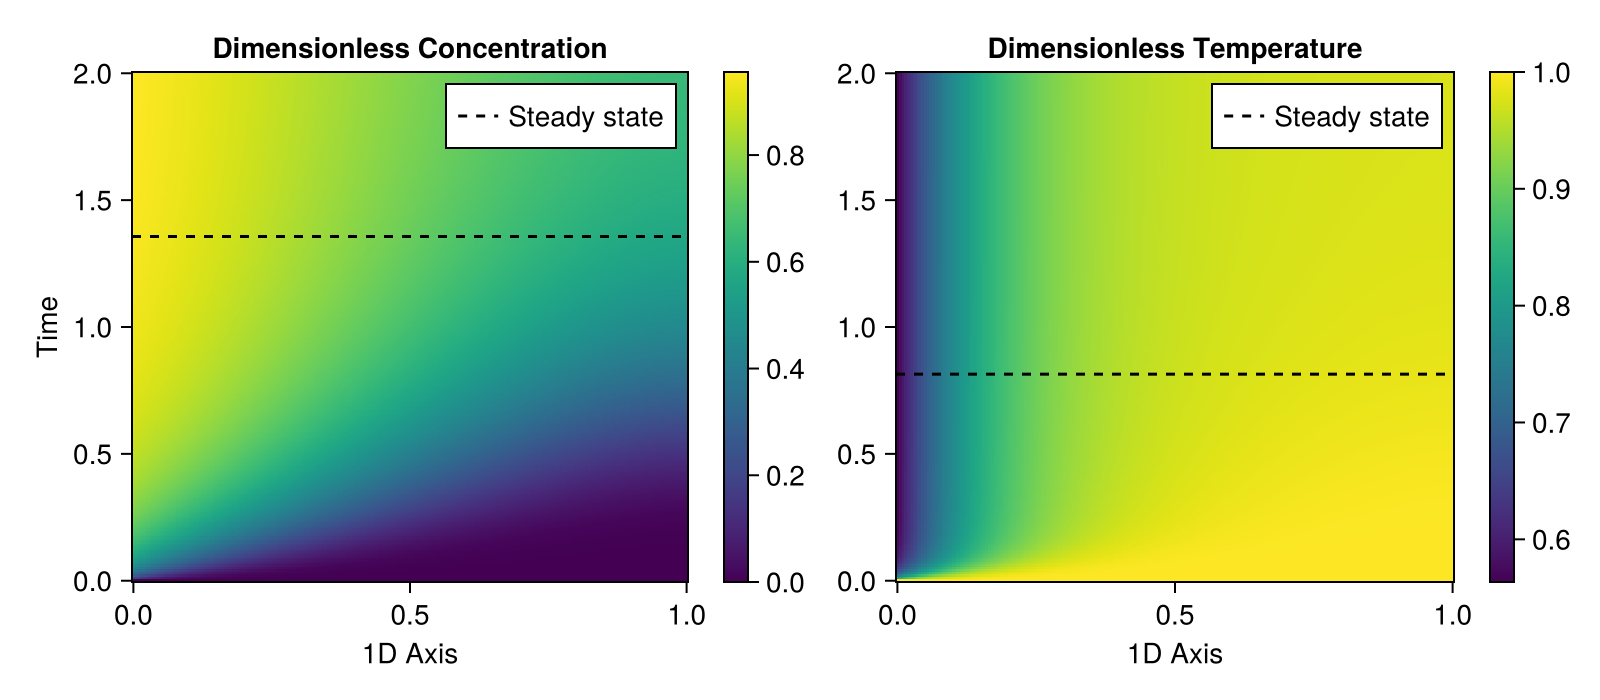

In [7]:
f = Figure(size = (800, 350))
ax1 = Axis(f[1, 1], xlabel="1D Axis", ylabel="Time", title="Dimensionless Concentration")
ax2 = Axis(f[1, 3], xlabel="1D Axis", title="Dimensionless Temperature")

hm1 = heatmap!(ax1, zs, ts, Cs)
hlines!(ax1, tss_C, color=:black, linestyle=:dash, label="Steady state")
axislegend(ax1, position = :rt)
Colorbar(f[1, 2], hm1)

hm2 = heatmap!(ax2, zs, ts, Ts)
hlines!(ax2, tss_T, color=:black, linestyle=:dash, label="Steady state")
axislegend(ax2, position = :rt)
Colorbar(f[1, 4], hm2)

f